# 10 Convolutional Neural Networks
CNNs) are a specialized type of artificial neural network designed for processing grid-like data, such as images. They are particularly well-suited for computer vision tasks due to their ability to automatically learn hierarchical representations from raw pixel values.
CNNs have been highly successful in various applications, such as image classification, object detection, image segmentation, and more.

In [1]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import load_model

2024-08-10 09:43:39.672781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 09:43:39.699950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 09:43:39.699977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 09:43:39.724918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 09:43:41.555800: W tensorflow/compiler/tf

1. Dataset Preparation:
* Download and preprocess the Caltech-256 dataset. You can use the tensorflow_datasets library to load the dataset conveniently.
* Normalize the pixel values of the images to the range [0, 1].
* Split the dataset into training and testing sets.

In [2]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]', 'test[:20%]'],
    with_info=True,
    as_supervised=True,
    data_dir='data',
    download=False
)

2024-08-10 09:43:47.036143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-10 09:43:47.344461: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
print('dataset_info: ', dataset_info)
print('train_dataset: ', train_dataset)
print('test_dataset: ',test_dataset)

dataset_info:  tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='data/caltech101/3.0.2',
    file_format=tfrecord,
    download_size=131.05 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffl

In [28]:
name_classes=dataset_info.features['label'].names

with open('custom_256/name_classes.pkl', 'wb') as f:
    pickle.dump(name_classes, f)

name_classes

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'background_google',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'faces',
 'faces_easy',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'leopards',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'motorbikes',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

In [5]:
num_classes = dataset_info.features['label'].num_classes

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

2. Build the CNN Model:
Define a CNN model with the following architecture:
* Convolutional Layer 1: 32 filters, kernel size (3x3), ReLU activation.
* Max Pooling Layer 1: Pooling size (2x2).
* Convolutional Layer 2: 64 filters, kernel size (3x3), ReLU activation.
* Max Pooling Layer 2: Pooling size (2x2).
* Flatten the feature maps.
* Fully Connected Layer 1: 128 units, ReLU activation.
* Output Layer: Number of units equal to the number of classes in the Caltech-101 dataset.

In [6]:
input_layer = layers.Input(shape=(224, 224, 3))

# First convolutional block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

# Second convolutional block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third convolutional block with (1, 1) convolution
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)  # (1, 1) Convolution
x = layers.MaxPooling2D((2, 2))(x)

# Fourth convolutional block with another (1, 1) convolution
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (1, 1), activation='relu', padding='same')(x)  # (1, 1) Convolution
output_layer = layers.MaxPooling2D((2, 2))(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

3. Training the Model:
* Compile the model with an appropriate optimizer and loss function.
* Train the model using the training dataset and validate it using the testing dataset.
* Observe the training process, including the loss and accuracy metrics.

In [7]:
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

#model.fit(train_dataset, epochs=10, validation_data=test_dataset)

4. Understanding Parameter Sharing and Local Receptive Fields:
* Analyze the number of learnable parameters in each layer of the CNN model.

¿What is parameter sharing? ¿What's its role in reducing the model's complexity?

In [8]:
#num_params = model.count_params()
#print(f"Number of trainable parameters in the model: {num_params}")

5. Evaluation and Interpretation:
* Evaluate the model's performance on the testing dataset and calculate the accuracy.
* Visualize some misclassified images and discuss the possible reasons for misclassifications.

In [9]:
#loss, accuracy = model.evaluate(test_dataset)
#print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

In [24]:
model.save('custom_256/model_custom.h5')

In [11]:
model = load_model('custom_256/model_custom.h5')

In [12]:
#misclassified_images = []
#misclassified_labels = []
#for image, label in test_dataset:
#    predictions = model.predict(image)
#    predicted_label = np.argmax(predictions, axis=1)
#    misclassified_idx = np.where(predicted_label != label.numpy())[0]
#    for idx in misclassified_idx:
#        misclassified_images.append(image[idx])
#        misclassified_labels.append(predicted_label[idx])

#num_images = len(misclassified_images)
#grid_size = int(np.ceil(np.sqrt(num_images)))

#plt.figure(figsize=(10, 10))
#for i in range(len(misclassified_images)):
#    plt.subplot(grid_size, grid_size, i+1)
#    plt.imshow(misclassified_images[i])
#    plt.title(f"Predicted: {misclassified_labels[i]}")
#    plt.axis('off')
#plt.show()

6. Pick a sample image and show the feature maps activated by the convolutional layers

In [13]:
#niceclassified_images = []
#niceclassified_labels = []
#for image, label in test_dataset:
#    predictions = model.predict(image)
#    predicted_label = np.argmax(predictions, axis=1)
#    niceclassified_idx = np.where(predicted_label == label.numpy())[0]
#    for idx in niceclassified_idx:
#        niceclassified_images.append(image[idx])
#        niceclassified_labels.append(predicted_label[idx])

#num_images = len(niceclassified_images)
#grid_size = int(np.ceil(np.sqrt(num_images)))

#plt.figure(figsize=(10, 10))
#for i in range(len(niceclassified_images)):
#    plt.subplot(grid_size, grid_size, i+1)
#    plt.imshow(niceclassified_images[i])
#    plt.title(f"Predicted: {niceclassified_labels[i]}")
#    plt.axis('off')
#plt.show()

In [14]:
#sample_image, _ = next(itertools.islice(iter(test_dataset), 0, 1))
#sample_image = sample_image[:1]

#activation_model = models.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# activation_model = models.Model(inputs=model.input, outputs=model.layers[4].output)
#activations = activation_model.predict(sample_image)

#plt.figure(figsize=(10, 5))
#for i, activation in enumerate(activations):
#    plt.subplot(2, 4, i+1)
#    try:
#        plt.imshow(activation[0, :, :, 0], cmap='viridis')
#    except:
#        pass
#    plt.title(f"Activation {i+1}")
#    plt.axis('off')
#plt.show()

In [15]:
def extract_features(dataset):
    features = []
    labels = []
    imgs = []
    for images, lbls in dataset:
        imgs.append(images)
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    return features, labels,imgs



In [16]:
train_features, train_labels, train_img = extract_features(train_dataset)
test_features, test_labels, test_img = extract_features(test_dataset)

2024-08-10 09:43:50.818933: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-08-10 09:43:50.829253: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-08-10 09:43:51.738339: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-08-10 09:43:51.806407: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-08-10 09:43:53.030501: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/

2024-08-10 09:45:06.050877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-08-10 09:45:41.237670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
train_features_flat_custom = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat_custom = np.array([label for batch in train_labels for label in batch])
train_img_flat_custom = np.array([img for batch in train_img for img in batch])
test_img_flat_custom = np.array([img for batch in test_img for img in batch])


In [18]:
np.save('custom_256/train_features_custom.npy', train_features_flat_custom)
np.save('custom_256/train_labels_custom.npy', train_labels_flat_custom)
np.save('custom_256/train_img_custom.npy', train_img_flat_custom)
np.save('custom_256/test_img_custom.npy', test_img_flat_custom)

In [19]:
train_features_flat_custom = np.load('custom_256/train_features_custom.npy')
train_labels_flat_custom = np.load('custom_256/train_labels_custom.npy')
train_img_flat_custom = np.load('custom_256/train_img_custom.npy')
test_img_flat_custom = np.load('custom_256/test_img_custom.npy')

In [20]:
nn_model_custom = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(train_features_flat_custom)

In [27]:
import pickle

with open('custom_256/nn_model_custom.pkl', 'wb') as f:
    pickle.dump(nn_model_custom, f)

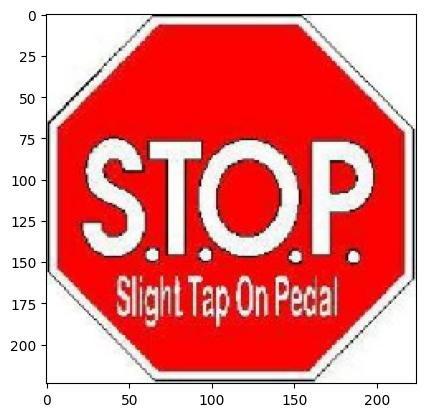

In [89]:
imagen_consulta_custom =test_img_flat_custom[14]
imagen_consulta_custom = tf.expand_dims(imagen_consulta_custom, axis=0)

from PIL import Image

image_array_save = tf.squeeze(imagen_consulta_custom, axis=0).numpy()  # Now shape is (224, 224, 3)

# Rescale the pixel values to [0, 255] if they are in [0, 1]
if image_array_save.max() <= 1.0:
    image_array_save = (image_array_save * 255).astype(np.uint8)

# Convert to PIL Image
image = Image.fromarray(image_array_save)

# Save the image
image.save('output_image.jpg')



plt.imshow(imagen_consulta_custom[0])

In [90]:
query_features_custom = model.predict([imagen_consulta_custom]).flatten().reshape(1, -1)
# Find the nearest neighbors
distances_custom, indices_custom = nn_model_custom.kneighbors(query_features_custom)
print("Indices of nearest neighbors custom:", indices_custom)
print("Distances to nearest neighbors custom:", distances_custom)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Indices of nearest neighbors custom: [[ 800  300 1895   86 1558  994 1064 1220 1965   13]]
Distances to nearest neighbors custom: [[1.87603215 2.10038284 2.12508957 2.16814653 2.18199407 2.30161049
  2.30798748 2.33024893 2.33207831 2.33973845]]


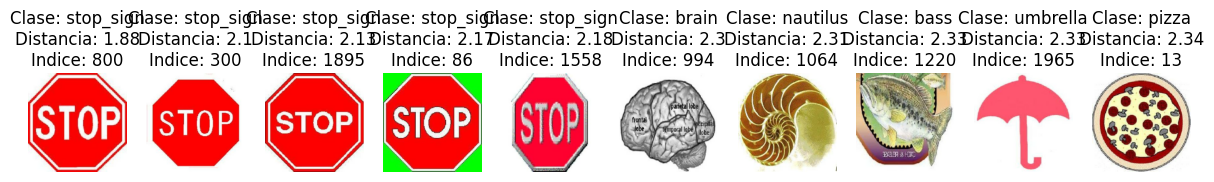

In [91]:
nearest_images =[]
nearest_labels = []
# Recuperar las imágenes de los vecinos más cercanos usando los índices
nearest_images = [train_img_flat_custom[i] for i in indices_custom.flatten()]
nearest_labels = [train_labels_flat_custom[i] for i in indices_custom.flatten()]
plt.figure(figsize=(15, 3))  # Ajustar el tamaño de la figura
for i, image in enumerate(nearest_images):
    plt.subplot(1, 10, i + 1)
    plt.imshow(image)
    plt.title("Clase: " + name_classes[nearest_labels[i]] + "\nDistancia: " + str(round(distances_custom[0][i], 2))+ "\nIndice: " + str(indices_custom[0][i]))
    plt.axis('off')
plt.show()